In [1]:
import tqdm
import itertools
import types
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

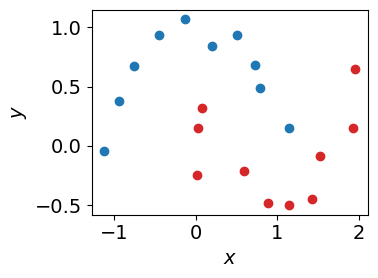

In [3]:
N = 20
X_numpy, y_numpy = make_moons(n_samples=N, noise=0.1, random_state=42)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
ax.scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#ax.set_xlim([-1.4, 2.4])
#ax.set_ylim([-0.9, 1.4])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [4]:
def train_one_epoch(model, criterion, optimizer, X, y, num_samples=1):
    model.train()
    optimizer.zero_grad()
    
    avg_metrics = {}
    for _ in range(num_samples):
        
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
        metrics['loss'].backward()
        
        for key, value in metrics.items():
            avg_metrics.setdefault(key, 0.0)
            avg_metrics[key] += (1/num_samples) * value.item()
        
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data.mul_(1/num_samples)

    optimizer.step()
    return avg_metrics

def evaluate(model, criterion, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        params = utils.flatten_params(model)
        metrics = criterion(y, logits, params, len(X))
    return metrics

In [7]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_preds1 = torch.nn.functional.sigmoid(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))).reshape(xx.shape)
    #torch.save(de_elbo_preds, 'classification_de_elbo_preds.pt')

100%|██████████| 10000/10000 [04:20<00:00, 38.34it/s]


In [34]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4)))*torch.randn((1024,)))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 1)

    if train_metrics['loss'] < best_metric:
        best_state_dict = model.state_dict()
        best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_preds2 = torch.nn.functional.sigmoid(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))).reshape(xx.shape)
    #torch.save(de_elbo_preds, 'classification_de_elbo_preds.pt')

100%|██████████| 10000/10000 [00:39<00:00, 255.78it/s]


In [73]:
model = layers.RandomFeatureGaussianProcess(in_features=2, out_features=1, learnable_lengthscale=True, learnable_outputscale=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4)))*torch.randn((1024, 1024,)))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=torch.nn.BCEWithLogitsLoss())

init_state_dict = model.state_dict()
best_state_dict = None
best_metric = np.inf

for lr, weight_decay in itertools.product([0.1, 0.01, 0.001, 0.0001], [0.0]):
    
    model.load_state_dict(init_state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in tqdm.tqdm(range(10_000)):
        train_metrics = train_one_epoch(model, criterion, optimizer, X, y, 5)

        if train_metrics['loss'] < best_metric:
            best_state_dict = model.state_dict()
            best_metric = train_metrics['loss']
        
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    de_elbo_preds2 = torch.nn.functional.sigmoid(model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))).reshape(xx.shape)
    #torch.save(de_elbo_preds, 'classification_de_elbo_preds.pt')

  1%|          | 108/10000 [01:16<1:56:46,  1.41it/s]

KeyboardInterrupt



In [62]:
torch.nn.functional.softplus(model.sigma_param)

tensor([[7.7631e+01, 5.1917e+00, 1.6871e+01,  ..., 5.8810e-01, 8.2391e+00,
         6.3244e-01],
        [6.9316e-01, 7.7631e+01, 7.8045e+00,  ..., 3.7389e-01, 1.6898e+00,
         1.4782e+00],
        [6.9315e-01, 6.9313e-01, 7.7631e+01,  ..., 1.2538e-10, 2.2644e+00,
         3.3055e+00],
        ...,
        [6.9312e-01, 6.9306e-01, 6.9310e-01,  ..., 7.7631e+01, 7.8489e+00,
         8.9619e-04],
        [6.9312e-01, 6.9307e-01, 6.9311e-01,  ..., 6.9320e-01, 7.7631e+01,
         8.1111e-05],
        [6.9311e-01, 6.9305e-01, 6.9310e-01,  ..., 6.9321e-01, 6.9307e-01,
         7.7631e+01]], grad_fn=<SoftplusBackward0>)

In [74]:
model.load_state_dict(best_state_dict)
model.eval()

with torch.no_grad():
    model.use_posterior(True)
    xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))
    logits = torch.stack([model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)) for _ in range(100)])
    de_elbo_preds2 = torch.nn.functional.sigmoid(logits.mean(dim=0)).reshape(xx.shape)
    #torch.save(de_elbo_preds, 'classification_de_elbo_preds.pt')

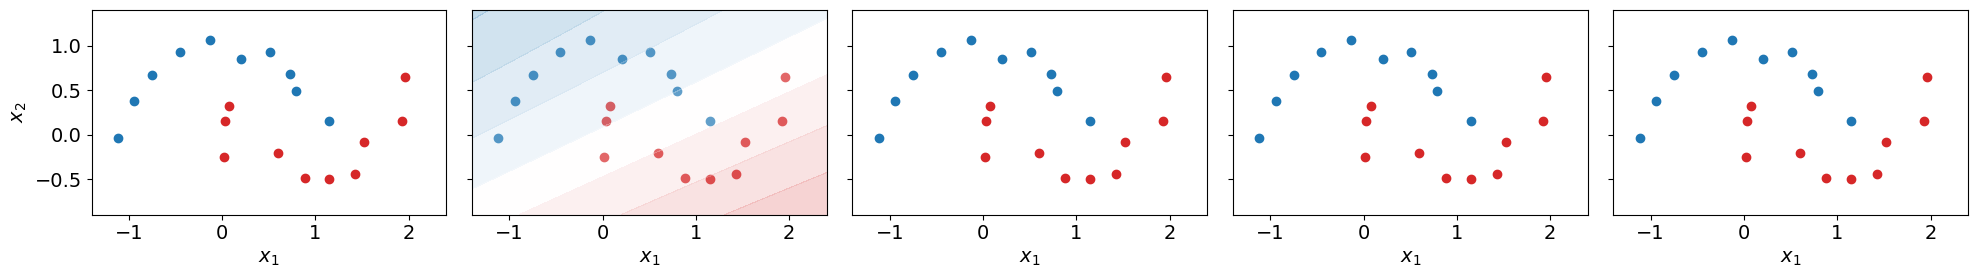

In [75]:
colors = ['#1F77B4', '#5799C7', '#8FBBDA', '#C7DDED', '#FFFFFF', '#F5C9CA', '#EB9394', '#E15D5E', '#D62728']
cmap = LinearSegmentedColormap.from_list('bwr', colors)

xx, yy = np.meshgrid(np.arange(-1.4, 2.5, 0.05), np.arange(-0.9, 1.5, 0.05))

ncols, nrows = 5, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')

axs[0].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[0].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#axs[0].contourf(xx, yy, de_elbo_preds1, alpha=0.3, cmap=cmap)
axs[0].set_xlim([-1.4, 2.4])
axs[0].set_ylim([-0.9, 1.4])
axs[0].set_xlabel(r'$x_1$')
axs[0].set_ylabel(r'$x_2$')

axs[1].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[1].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
axs[1].contourf(xx, yy, de_elbo_preds2, alpha=0.3, cmap=cmap)
axs[1].set_xlim([-1.4, 2.4])
axs[1].set_ylim([-0.9, 1.4])
axs[1].set_xlabel(r'$x_1$')

axs[2].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[2].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#axs[2].contourf(xx, yy, de_elbo_preds3, alpha=0.3, cmap=cmap)
axs[2].set_xlim([-1.4, 2.4])
axs[2].set_ylim([-0.9, 1.4])
axs[2].set_xlabel(r'$x_1$')

axs[3].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[3].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#axs[3].contourf(xx, yy, de_elbo_preds4, alpha=0.3, cmap=cmap)
axs[3].set_xlim([-1.4, 2.4])
axs[3].set_ylim([-0.9, 1.4])
axs[3].set_xlabel(r'$x_1$')

axs[4].scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color='#1F77B4')
axs[4].scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color='#D62728')
#axs[4].contourf(xx, yy, de_elbo_preds5, alpha=0.3, cmap=cmap)
axs[4].set_xlim([-1.4, 2.4])
axs[4].set_ylim([-0.9, 1.4])
axs[4].set_xlabel(r'$x_1$')

fig.tight_layout()
fig.savefig('classification_demo.pdf', bbox_inches='tight')
plt.show()